This notebook has been adapted from CS294-158-SP20 [AutoRegressive Models](https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/solutions/hw1_solutions.ipynb#scrollTo=NWualafa-tpD) by Abbeel et al. and [Autoregressive Models — PixelCNN](https://towardsdatascience.com/autoregressive-models-pixelcnn-e30734ede0c1) by Walter Pinaya.

# AutoRegressive Models

In [1]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Fitting a Simple 1D Discrete Distribution

In [3]:
# Let's first create some simple data distributions.
def sample_data_1():
  # Normally distributed random variable with 20 discrete values.
  count = 100
  rand = np.random.RandomState(0)
  samples = 0.4 + 0.1 * rand.randn(count)
  data = np.digitize(samples, np.linspace(0.0, 1.0, 20))
  split = int(0.8 * len(data))
  train_data, test_data = data[:split], data[split:]
  return train_data, test_data


def sample_data_2():
  # Mixture of 2 Normal distributions with 100 discrete values.
  count = 10000
  rand = np.random.RandomState(0)
  a = 0.3 + 0.1 * rand.randn(count)
  b = 0.8 + 0.05 * rand.randn(count)
  mask = rand.rand(count) < 0.5
  samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
  data = np.digitize(samples, np.linspace(0.0, 1.0, 100))
  split = int(0.8 * len(data))
  train_data, test_data = data[:split], data[split:]
  return train_data, test_data

In [4]:
def visualize_data(train_data, test_data, d):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.set_title('Train Data')
  ax1.hist(train_data, bins=np.arange(d) - 0.5, density=True)
  ax1.set_xlabel('x')
  ax2.set_title('Test Data')
  ax2.hist(test_data, bins=np.arange(d) - 0.5, density=True)
  plt.show()

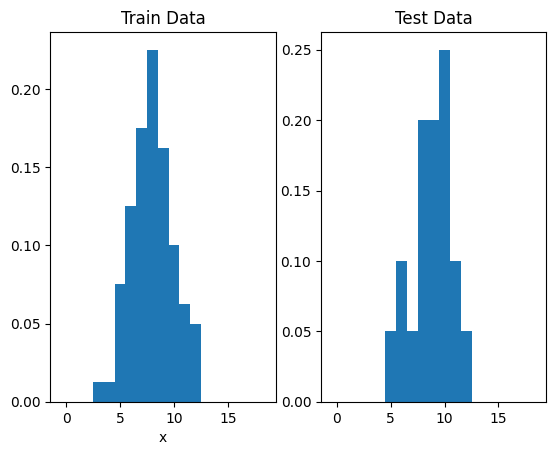

In [5]:
train_data_1, test_data_1 = sample_data_1()
visualize_data(train_data_1, test_data_1, 20)

In [6]:
train_data_1

array([11,  9, 10, 12, 12,  6, 10,  8,  8,  9,  8, 11, 10,  8,  9,  9, 11,
        8,  9,  6,  3,  9, 10,  7, 12,  5,  8,  8, 11, 11,  8,  9,  6,  4,
        7,  8, 10, 10,  7,  8,  6,  5,  5, 12,  7,  7,  6, 10,  5,  8,  6,
        9,  7,  6,  8,  9,  8,  9,  7,  7,  7,  7,  7,  5,  8,  7,  5,  9,
        6,  8,  9,  8, 10,  6,  9,  7,  6,  7,  8,  8])

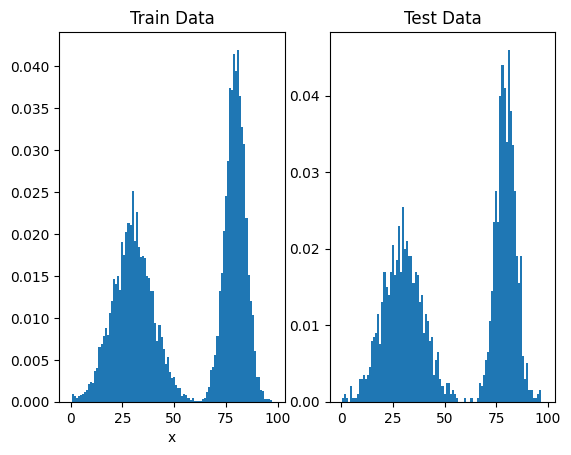

In [7]:
train_data_2, test_data_2 = sample_data_2()
visualize_data(train_data_2, test_data_2, 100)

We will create a simple model which learns the distribution of our data. The model will as many parameters as the size of sample space (discrete values possible) and will try to learn the probability of each value based on the training data. We can apply softmax on the parameters to convert them to probabilities.

Let $\theta = (\theta_0, \dots, \theta_{n-1}) \in \mathbb{R}^{n}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero.

In [8]:
class HistogramModel(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)

  def loss(self, x):
    # Each of the possible discrete value can be treated as a class. Then our loss function is just categorical crossentropy.
    logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1) # batch_size x d
    return F.cross_entropy(logits, x.long())

  def get_distribution(self):
    # Convert the parameters into a categorical distribution by applying softmax.
    distribution = F.softmax(self.logits, dim=0)
    return distribution.detach().cpu().numpy()

In [9]:
# Training and Evaluation Function
def train(model, train_loader, optimizer, epoch):
  model.train()

  train_losses = []
  for x in train_loader:
    x = x.to(device).contiguous()
    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.to(device).contiguous()
      loss = model.loss(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()


### Data 1

In [10]:
# For data 1 we have 20 discrete values in sample space
model_1 = HistogramModel(20).to(device)
train_loader_1 = data.DataLoader(train_data_1, batch_size=128, shuffle=True)
test_loader_1 = data.DataLoader(test_data_1, batch_size=128)

In [11]:
# Training loop
epochs = 20
lr = 0.1
optimizer = optim.Adam(model_1.parameters(), lr=lr)

train_losses = []
test_losses = [eval_loss(model_1, test_loader_1)]
for epoch in range(epochs):
  model_1.train()
  train_losses.extend(train(model_1, train_loader_1, optimizer, epoch))
  test_loss = eval_loss(model_1, test_loader_1)
  test_losses.append(test_loss)
  print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

Epoch 0, Test loss 2.8802
Epoch 1, Test loss 2.7747
Epoch 2, Test loss 2.6792
Epoch 3, Test loss 2.5945
Epoch 4, Test loss 2.5199
Epoch 5, Test loss 2.4544
Epoch 6, Test loss 2.3974
Epoch 7, Test loss 2.3484
Epoch 8, Test loss 2.3070
Epoch 9, Test loss 2.2724
Epoch 10, Test loss 2.2439
Epoch 11, Test loss 2.2208
Epoch 12, Test loss 2.2024
Epoch 13, Test loss 2.1881
Epoch 14, Test loss 2.1772
Epoch 15, Test loss 2.1690
Epoch 16, Test loss 2.1628
Epoch 17, Test loss 2.1581
Epoch 18, Test loss 2.1544
Epoch 19, Test loss 2.1513


Text(0, 0.5, 'Loss')

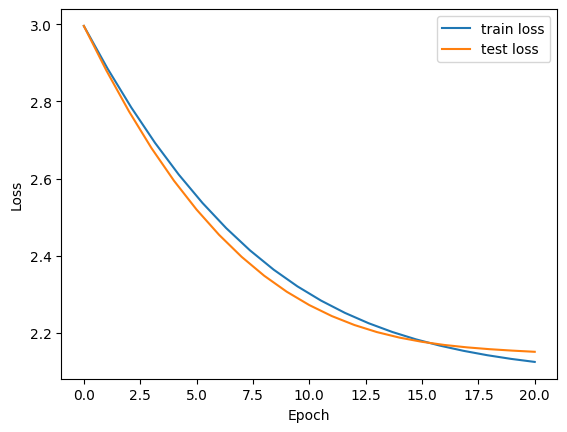

In [12]:
plt.figure()
n_epochs = len(test_losses) - 1
x_train = np.linspace(0, n_epochs, len(train_losses))
x_test = np.arange(n_epochs + 1)

plt.plot(x_train, train_losses, label='train loss')
plt.plot(x_test, test_losses, label='test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

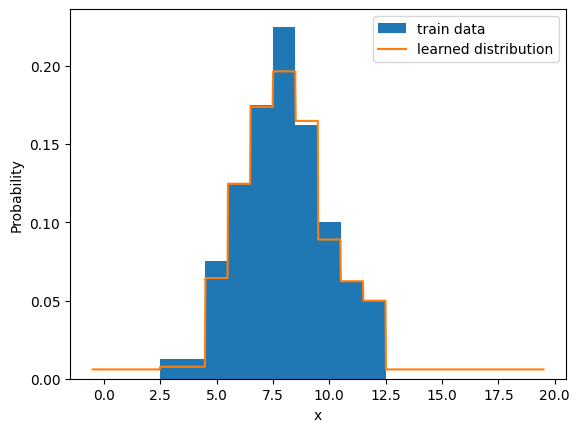

In [13]:
d = model_1.d
plt.figure()
plt.hist(train_data_1, bins=np.arange(d) - 0.5, label='train data', density=True)

x = np.linspace(-0.5, d - 0.5, 1000)
y = model_1.get_distribution().repeat(1000 // d)
plt.plot(x, y, label='learned distribution')

plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()

In [14]:
model_1.get_distribution()

array([0.00594759, 0.00594759, 0.00594759, 0.00767729, 0.00767729,
       0.06432723, 0.12462811, 0.17380813, 0.19645455, 0.1647859 ,
       0.08898032, 0.06231226, 0.04987298, 0.00594759, 0.00594759,
       0.00594759, 0.00594759, 0.00594759, 0.00594759, 0.00594759],
      dtype=float32)

### Data 2

In [15]:
# For data 2 we have 20 discrete values in sample space
model_2 = HistogramModel(100).to(device)
train_loader_2 = data.DataLoader(train_data_2, batch_size=128, shuffle=True)
test_loader_2 = data.DataLoader(test_data_2, batch_size=128)

In [16]:
epochs = 20
lr = 0.1
optimizer = optim.Adam(model_2.parameters(), lr=lr)

train_losses = []
test_losses = [eval_loss(model_2, test_loader_2)]
for epoch in range(epochs):
  model_2.train()
  train_losses.extend(train(model_2, train_loader_2, optimizer, epoch))
  test_loss = eval_loss(model_2, test_loader_2)
  test_losses.append(test_loss)
  print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

Epoch 0, Test loss 4.0432
Epoch 1, Test loss 4.0498
Epoch 2, Test loss 4.0430
Epoch 3, Test loss 4.0415
Epoch 4, Test loss 4.0412
Epoch 5, Test loss 4.0525
Epoch 6, Test loss 4.0497
Epoch 7, Test loss 4.0391
Epoch 8, Test loss 4.0453
Epoch 9, Test loss 4.0409
Epoch 10, Test loss 4.0406
Epoch 11, Test loss 4.0398
Epoch 12, Test loss 4.0403
Epoch 13, Test loss 4.0447
Epoch 14, Test loss 4.0451
Epoch 15, Test loss 4.0476
Epoch 16, Test loss 4.0421
Epoch 17, Test loss 4.0411
Epoch 18, Test loss 4.0475
Epoch 19, Test loss 4.0414


Text(0, 0.5, 'Loss')

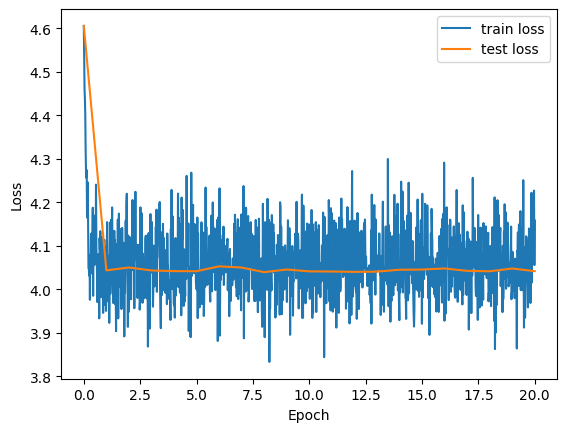

In [17]:
plt.figure()
n_epochs = len(test_losses) - 1
x_train = np.linspace(0, n_epochs, len(train_losses))
x_test = np.arange(n_epochs + 1)

plt.plot(x_train, train_losses, label='train loss')
plt.plot(x_test, test_losses, label='test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

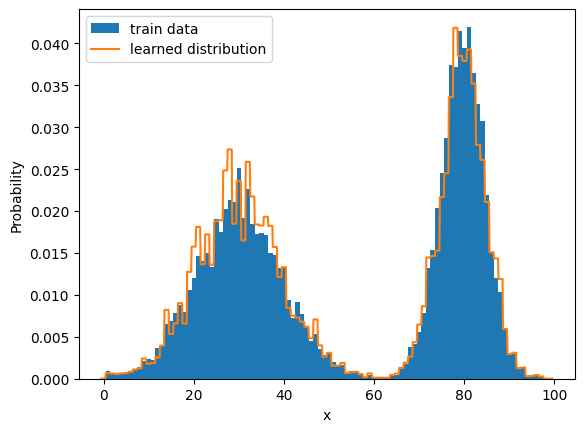

In [18]:
d = model_2.d
plt.figure()
plt.hist(train_data_2, bins=np.arange(d) - 0.5, label='train data', density=True)

x = np.linspace(-0.5, d - 0.5, 1000)
y = model_2.get_distribution().repeat(1000 // d)
plt.plot(x, y, label='learned distribution')

plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()

## PixelCNN

PixelCNN was introduced by DeepMind in 2016 (Oord et al., 2016), and this model started one of the most promising families of autoregressive generative models. PixelCNN is a deep neural network that captures the distribution of dependencies between pixels in its parameters. It sequentially generates one pixel at a time in an image along the two spatial dimensions by looking at the previous pixels in its receptive field.

![PixelCNN](https://tensorflowkorea.files.wordpress.com/2016/11/pixel-cnn1.png)

[Source](https://tensorflow.blog/2016/11/29/pixelcnn-1601-06759-summary/)

When processing the information of a central pixel, the convolutional filter considers all the pixels around it to calculate the output feature map, not only the previous pixels. Therefore, Masks are adopted to block information flow from pixels not yet predicted. In the PixelCNN, there are two types of masks:

1. **Mask type A:** This mask is applied only to the first convolutional layer. It restricts access to the pixel of interest by zeroing the central pixel in the mask. This way, we guarantee that the model will not access the pixel that it is about to predict (in red in the figure below).<br>
2. **Mask type B:** This mask is applied to all the subsequent convolutional layers and relaxes the restrictions of mask A by allowing the connection from a pixel to itself. This is important in order to account for the pixel prediction of the first layer.

![Masked Conv](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*fWOza0sytZOXB2N1Mjb88Q.png)

[Source](https://towardsdatascience.com/autoregressive-models-pixelcnn-e30734ede0c1)

In [19]:
class MaskConv2d(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    assert mask_type == 'A' or mask_type == 'B'
    super().__init__(*args, **kwargs)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)

  def forward(self, input):
    # Multiply the weights with mask and then do standard convolution
    out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
    return out

  def create_mask(self, mask_type):
    k = self.kernel_size[0]
    self.mask[:, :, :k // 2] = 1
    self.mask[:, :, k // 2, :k // 2] = 1
    # If mask type B then also use the center pixel
    if mask_type == 'B':
      self.mask[:, :, k // 2, k // 2] = 1

In [20]:
# Layer Normalization applied on the last dimension
class LayerNorm(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x = super().forward(x)
    return x.permute(0, 3, 1, 2).contiguous()

In [21]:
class PixelCNN(nn.Module):
  def __init__(self, input_shape, n_colors, n_filters=64,
               kernel_size=7, n_layers=5):
    super().__init__()
    assert n_layers >= 2
    n_channels = input_shape[0]

    # First an "A" Masked layers and then a few "B" Masked Layer
    model = nn.ModuleList([MaskConv2d('A', n_channels, n_filters,
                                      kernel_size=kernel_size,
                                      padding=kernel_size // 2)])
    for _ in range(n_layers):
      model.extend([LayerNorm(n_filters),
                    nn.ReLU(),
                    MaskConv2d('B', n_filters, n_filters,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2)])

    model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_filters, 1)])
    model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_colors*n_channels, 1)])

    self.net = model
    self.input_shape = input_shape
    self.n_colors = n_colors
    self.n_channels = n_channels

  def forward(self, x, cond=None):
    batch_size = x.shape[0]
    # Transforming input to [-1,1]
    out = (x.float() - 0.5) / 0.5

    for layer in self.net:
      out = layer(out)

    return out.view(batch_size, self.n_colors, *self.input_shape)

  def loss(self, x, cond=None):
    return F.cross_entropy(self(x), x.long())

  def sample(self, n, cond=None):
    samples = torch.zeros(n, *self.input_shape).cuda()
    # We predict the probability and then sample each pixel iteratively.
    with torch.no_grad():
      for r in range(self.input_shape[1]):
        for c in range(self.input_shape[2]):
          for k in range(self.n_channels):
            logits = self.forward(samples, cond=cond)[:, :, k, r, c]
            probs = F.softmax(logits, dim=1)
            samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
    return samples.permute(0, 2, 3, 1).cpu().numpy()


# p(x(i,j) | p(x(i, j-1)), p(x(i,j-2)), p(x(i, 1)), p(x(i-1, c)), p(x(i-1, c-1))...p(x(i-1,1)), p(x(i-2, c)),-----p(x(1,1)))

In [22]:
transform_steps = Compose([
            ToTensor(),
            Lambda(lambda t: (t > 0.5).float())
])

In [23]:
# We will be using the mnist digit data
mnist_train_dataset = datasets.MNIST(root="minist_data/", download=True, transform=transform_steps)
mnist_test_dataset = datasets.MNIST(root="minist_data/", download=True, train=False, transform=transform_steps)

100%|██████████| 9912422/9912422 [00:00<00:00, 103281375.75it/s]


Extracting minist_data/MNIST/raw/train-images-idx3-ubyte.gz to minist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6032053.27it/s]

Extracting minist_data/MNIST/raw/train-labels-idx1-ubyte.gz to minist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25251723.02it/s]

Extracting minist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to minist_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22281320.20it/s]


Extracting minist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to minist_data/MNIST/raw



In [24]:
# Initializing pytorch dataloader
train_dataloader = data.DataLoader(mnist_train_dataset, batch_size=128, shuffle=True)
test_dataloader = data.DataLoader(mnist_test_dataset, batch_size=128)

In [25]:
pixel_cnn = PixelCNN((1, 28, 28), 2, n_layers=5).to(device)

In [26]:
def train(model, train_loader, optimizer, epoch):
  model.train()

  train_losses = []
  for x,_ in train_loader:
    x = x.to(device).contiguous()
    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x,_ in data_loader:
      x = x.to(device).contiguous()
      loss = model.loss(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()


In [27]:
# Training Loop
epochs = 10
lr = 1e-3
optimizer = optim.Adam(pixel_cnn.parameters(), lr=lr)

train_losses = []
test_losses = [eval_loss(pixel_cnn, test_dataloader)]
for epoch in range(epochs):
  pixel_cnn.train()
  train_losses.extend(train(pixel_cnn, train_dataloader, optimizer, epoch))
  test_loss = eval_loss(pixel_cnn, test_dataloader)
  test_losses.append(test_loss)
  print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

Epoch 0, Test loss 0.0860
Epoch 1, Test loss 0.0819
Epoch 2, Test loss 0.0788
Epoch 3, Test loss 0.0783
Epoch 4, Test loss 0.0775
Epoch 5, Test loss 0.0766
Epoch 6, Test loss 0.0766
Epoch 7, Test loss 0.0758
Epoch 8, Test loss 0.0764
Epoch 9, Test loss 0.0762


Text(0, 0.5, 'Loss')

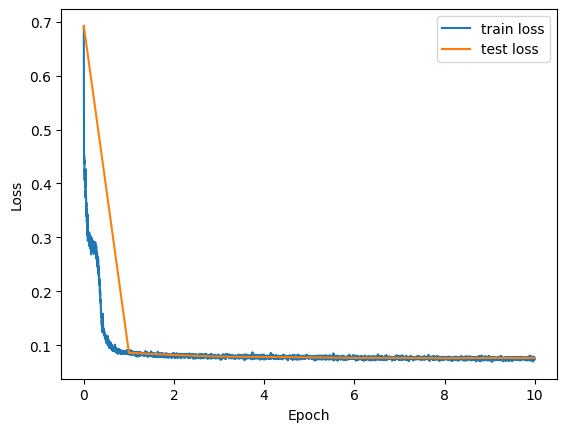

In [28]:
plt.figure()
n_epochs = len(test_losses) - 1
x_train = np.linspace(0, n_epochs, len(train_losses))
x_test = np.arange(n_epochs + 1)

plt.plot(x_train, train_losses, label='train loss')
plt.plot(x_test, test_losses, label='test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

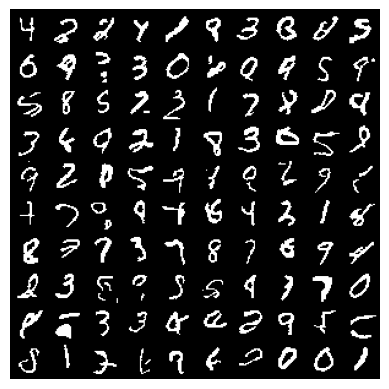

In [29]:
from torchvision.utils import make_grid
samples = pixel_cnn.sample(100)
samples = torch.FloatTensor(samples).permute(0, 3, 1, 2)
grid_img = make_grid(samples, nrow=10)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [30]:
pixel_cnn

PixelCNN(
  (net): ModuleList(
    (0): MaskConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaskConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): MaskConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): MaskConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
    (12): MaskConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (13): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (14): ReLU()
    (15): MaskConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (16): ReLU()
    (17): MaskConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (18): ReLU()
  